# son-analyze tutorial notebook
___
## Setup
The `son_analyze` and `son_scikit` packages contains the function related to SONATA.
* `son_analyze` handles gathering data from the SONATA's SP or emulator
* `son_scikit` manipulates the metrics to work with analytics libraries 

In [1]:
import son_analyze
import son_scikit
print('Welcome to son-analyze v{} and son-scikit v{}.'.format(son_analyze.__version__, son_scikit.__version__))

Welcome to son-analyze v0.0.2 and son-scikit v0.0.2.


You can write and use Python files and call their functions inside your notebooks to keep them simples.

In [2]:
import helpers
print('You can use and tweak the python code in the helpers.py file (example: "{}")'.format(helpers.foobar()))

You can use and tweak the python code in the helpers.py file (example: "foobar")


## Fetching metrics
To keep this example self-contained, the data is read from a static file. The metrics are stored held in a `all_dataframes` variable.

In [3]:
import reprlib
import json
import arrow
import requests
from son_analyze.core.prometheus import PrometheusData
from son_scikit.hl_prometheus import build_sonata_df_by_id

all_dataframes = None
with open('empty_vnf1_sonemu_rx_count_packets_180.json') as raw:
    x = PrometheusData(raw.read())
    all_dataframes = build_sonata_df_by_id(x)

Each VNF has its own dataframe where metrics have a corresponding column. Here, the `empty_vnf1` VNF has a `sonemu_rx_count_packets` column for the monitored received packets on the network.

In [4]:
print('The dictonnary of all dataframes by VNF names: {}'.format(reprlib.repr(all_dataframes)))
print(all_dataframes['empty_vnf1'].head())

The dictonnary of all dataframes by VNF names: {'empty_vnf1':              ...s x 1 columns]}
                           sonemu_rx_count_packets
2017-06-29 09:25:59+00:00                 972312.0
2017-06-29 09:26:00+00:00                 972312.0
2017-06-29 09:26:01+00:00                 972312.0
2017-06-29 09:26:02+00:00                 972312.0
2017-06-29 09:26:03+00:00                 972312.0


## Basic plotting
From there we use the `df` and `ddf` variables as shortcuts, before plotting them.
* `df` is the main dataframe we are going to work with
* `ddf` contains the discrete difference of `df`

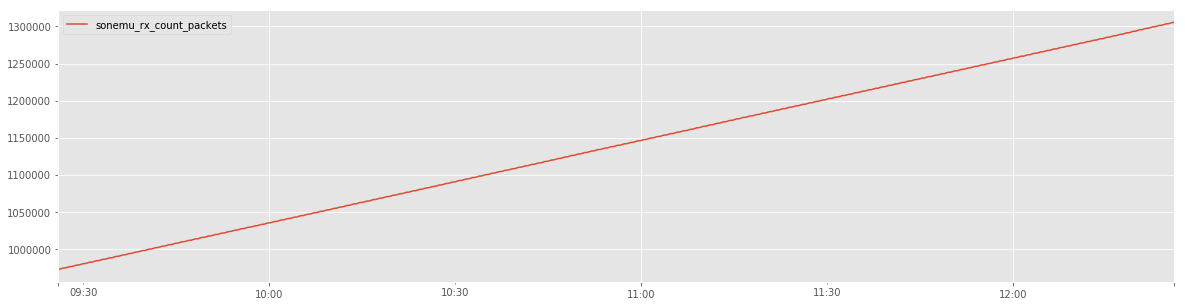

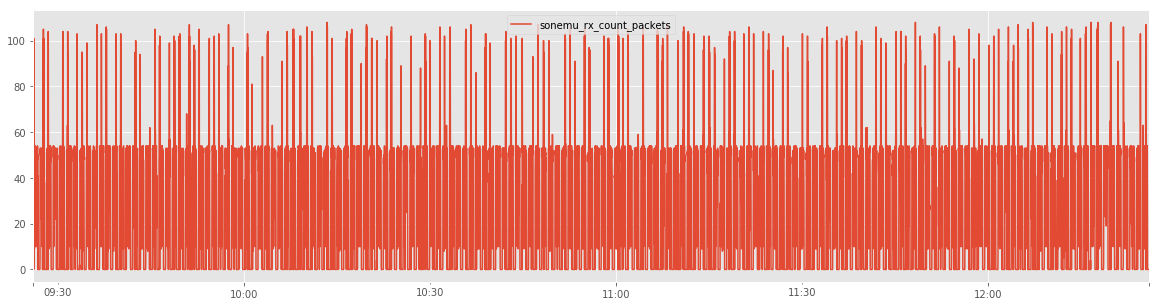

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 5.0)

df = all_dataframes['empty_vnf1']
ddf = df.diff().dropna()

df.plot();
ddf.plot();

## Injecting errors in the metrics

For this tutorial, we inject two errors in the metrics. This is done inside the `error_ddf` dataframe.

In [6]:
error_ddf = ddf.copy()
error_ddf.sonemu_rx_count_packets[1111] *= 2.6
error_ddf.sonemu_rx_count_packets[3333] *= 2.7

## Detecting anomalies

We use the `pyculiarity` package to detect anomalies in a dataframe using the `detect_ts` function.

In [7]:
from pyculiarity import detect_ts
import pandas as pd
import time


def f(x):
    dt = x.to_datetime()
    return time.mktime(dt.timetuple())

target = error_ddf
u = pd.DataFrame({'one': list(target.index.map(f)), 'two': target.sonemu_rx_count_packets})
results = detect_ts(u, max_anoms=0.004, alpha=0.01, direction='both') #, threshold='med_max')

/opt/conda/lib/python3.6/site-packages/pyculiarity/detect_ts.py:8: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/opt/conda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py:2776: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped_values = self._arrmap(self.values, mapper)
/opt/conda/lib/python3.6/site-packages/pyculiarity/detect_anoms.py:81: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  'value': (decomp['trend'] + decomp['seasonal']).truncate().convert_objects(convert_numeric=True)



The resulting plot clearly shows the 2 anomalies.


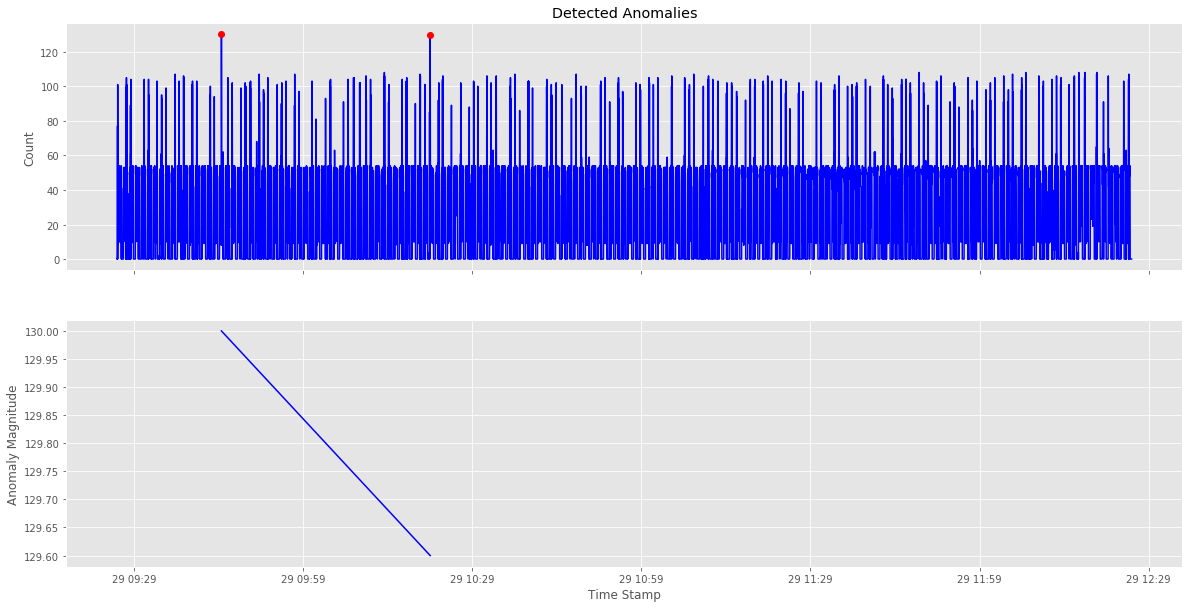

In [8]:
# make a nice plot
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
f, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(target.index, target.sonemu_rx_count_packets, 'b')
ax[0].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax[0].set_title('Detected Anomalies')
ax[1].set_xlabel('Time Stamp')
ax[0].set_ylabel('Count')
ax[1].plot(results['anoms'].index, results['anoms']['anoms'], 'b')
ax[1].set_ylabel('Anomaly Magnitude')
plt.show()